# Practice - Lecture 24

During this lecture we are going to use the library "benchmarking_qrc" to learn about quantum reservoir computing. But, we will also use numpy to allow new learners to experiment and built the own code.

In [1]:
# Only for local use
import os
import sys

repo_path = os.path.dirname(os.getcwd())
package_path = repo_path + "/src"
sys.path.append(package_path)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pathlib
from scipy.linalg import lstsq

import benchmarking_qrc as qrc
from benchmarking_qrc import run_memory_capacity as mc

### Exercise 0 - Define density matrix and hamiltonian

In this first exercise, we will learn to define a quantum state in the density matrix formalism and construct our first hamiltonian.

To define the initial state you can use `qrc.reservoir.initial_state(num_sites, dim_site)` or `numpy`.

In [3]:
def initial_reservoir(num_sites, dim_site):
    """Density matrix with all states at |0>

    Args:
        num_sites (int): Number of sites in the system
        dim_site (int): Hilbert dimension of each site.
    """
    # Put your code here: Prepare the state |00><00|
    return qrc.reservoir.initial_state(num_sites, dim_site)

In [4]:
def check_solution(solution, exp_solution):
    
    if solution.shape == exp_solution.shape:
        if np.all(solution == exp_solution):
            print("Correct!")
        else:
            print("Try again!")
    else:
        print("Try again!")

In [5]:
#solution = initial_reservoir(2, 2)
solution = initial_reservoir(2, 2)
exp_solution = np.array([[1, 0, 0, 0], [0]*4, [0]*4, [0]*4])

check_solution(solution, exp_solution)

Correct!


Now, we will define the dynamics of the system following this quadratic hamiltonian 
$$ H = \sum_{i,j=1}^{N}J_{ij}a_{i}^{\dagger}a_{j} $$
and the evolution operator associated to it: $e^{-iH\Delta t}$.

You can define the $J_{ij}$ coefficients with: 
- `qrc.hamiltonian.get_coefficients(num_sites, coef_range=[0, 1], seed=1)`.  

Define a quadratic hamiltonian with:  
- `qrc.hamiltonian.quadratic_op(num_sites, is_bosonic=..., dimensions=..., coefficients=...)`

and build the evolution operator with:
-  `qrc.hamiltonian.get_evolution_op(hamiltonian, dt=...)`


In [6]:
def my_hamiltonian(num_sites, dim_site):
    """Define previous quadratic hamiltonian

    Args:
        num_sites (int): Number of sites in the system.
        dim_site (int): Hilbert dimension of each site.
    """
    # Put your code here: Define J_ij coefficients
    J_ij = qrc.hamiltonian.get_coefficients(num_sites, coef_range=[0, 1], seed=1) 
    
    # Put your code here: Define quadratic hamiltonian
    return qrc.hamiltonian.quadratic_op(num_sites, is_bosonic=False, dimensions=dim_site, coefficients=J_ij)


def evolution_op(hamiltonian, delta_t):
    """Define the evolution operator related to the previous hamiltonian
    and let it evolves for 10 units.

    Args:
        hamiltonian (np.array): Matrix describing system dynamics.
        delta_t (float): Time we let the system evolve.
    """
    # Put your code here: Define evolution operator
    return qrc.hamiltonian.get_evolution_op(hamiltonian, dt=delta_t)
    
    

In [7]:
solution_hamiltonian = my_hamiltonian(2, 2)
solution_evolution = evolution_op(my_hamiltonian(2, 2), 10)


exp_sol_hamiltonian = np.array([
    [0.+0.j]*4, 
    [0.+0.j, 0.72+0.j, 0.+0.j  , 0.+0.j  ], 
    [0.+0.j, 0.+0.j  , 0.42+0.j, 0.+0.j  ], 
    [0.+0.j, 0.+0.j  , 0.+0.j  , 1.14+0.j]
])
exp_sol_evolution = np.array([
   [ 1.+0.j, 0.  +0.j ,  0.  +0.j  ,  0.  +0.j  ], 
   [ 0.+0.j, 0.61-0.8j,  0.  -0.j  ,  0.  +0.j  ],
   [ 0.+0.j, 0.  -0.j , -0.52+0.86j,  0.  +0.j  ],
   [ 0.+0.j, 0.  +0.j ,  0.  +0.j  ,  0.37+0.93j]
])

print("Checking solution hamiltonian...")
check_solution(np.around(solution_hamiltonian.todense(), 2), exp_sol_hamiltonian)
print("Checking evolution operator...")
check_solution(np.around(solution_evolution, 2), exp_sol_evolution)


Checking solution hamiltonian...
Correct!
Checking evolution operator...
Correct!


### Exercise 1 - Echo State Property

To avoid any possible effect of the initial conditions of the reservoir we always start with the wash out step before training the system. This step consists in injecting a set of inputs until the initial conditions become irrelevant.

So, in this section, you are going to compute how many iterations (wash-out steps) does your system need to wash out the initial conditions.

Each iteration have these 3 steps:
- Encoding classical data into a quantum state $\Longrightarrow \lvert \psi_k^{(e)} \rangle$.
    - qrc.reservoir.get_input_state(signal, dim, exc_state)
    - $ \lvert \psi_k^{(e=1)} \rangle = \sqrt{s_k}\lvert 0 \rangle + \sqrt{1-s_k}\lvert 1 \rangle$
- Injecting the quantum state into the reservoir $\Longrightarrow \rho(k)$.
    - qrc.reservoir.insert_input(input_state, initial_reservoir)
    - $ \rho(k\Delta t)= \rho_{1, k}^{(e)} \otimes {\rm Tr}_{1}\left\{ \rho\left(\left(k-1\right)\Delta t\right)\right\} $
- Evolving the reservoir $\Longrightarrow  \rho(k\Delta t)$.
    - qrc.reservoir.evolve(reservoir, evo_op)
    - $ \rho\left(k\Delta t\right)=e^{-iH\Delta t}\left[\rho_{1,k}^{(e)}\otimes {\rm Tr}_{1}\left\{ \rho\left(\left(k-1\right)\Delta t\right)\right\} \right]e^{iH\Delta t} $

So, let's start building these 3 functions:


In [12]:
# Use signal=0.25 to test your solution
def get_input_state(signal, dim_site, exc_state=1):
    """Encode classical data into a superposition state

        |ψ> = √s|0> + √1-s|1>

    Args:
        signal (float): Classical data.
        dim_site (int): Hilbert dimension of each site.
        exc_state (int): Highest superposition state
    """
    # Put your code here: 
    return qrc.reservoir.get_input_state(signal, dim_site, exc_state)


def inject_state(input_state, reservoir):
    """Introduce the input state into the reservoir

    Args:
        input_state (np.array): Classical data in a superposition state.
        reservoir (np.array): Current state of the quantum system

    """
    # Put your code here:
    return qrc.reservoir.insert_input(input_state, reservoir)


def evolve_reservoir(reservoir, evo_op):
    """Evolve the quantum system following the evolution operator.

    Args:
        reservoir (np.array): Current state of the quantum system
        evo_op (np.array): Evolution operator
    """
    # Put your code here:
    return qrc.reservoir.evolve(reservoir, evo_op)

In [28]:
# Use signal = 0.25
sol_input_state = get_input_state(0.25, dim_site=2)

# Inject the previous input and the initial reservoir
sol_inject_state = inject_state(sol_input_state, initial_reservoir(2, 2))

# Evolve the reservoir with the classical data
sol_evolve_reservoir = evolve_reservoir(sol_inject_state, evolution_op(my_hamiltonian(2, 2), 10))


exp_input_state = np.array([[np.sqrt(0.25)], [np.sqrt(1-0.25)]])
exp_inject_state = np.array([
   [ 0.25     , 0.  ,  0.433    ,  0.], 
   [ 0.       , 0.  ,  0.       ,  0.],
   [ 0.433    , 0.  ,  0.75     ,  0.],
   [ 0.       , 0.  ,  0.       ,  0.]
])
exp_evolve_reservoir = np.array([
   [ 0.25 +0.j  , 0.  +0.j ,  -0.22-0.37j,  0.  +0.j], 
   [ 0.   +0.j  , 0.  -0.j,   0.  -0.j   ,   0.  +0.j],
   [ -0.22+0.37j, 0.  -0.j ,  0.75+0.j   ,   0.  +0.j],
   [ 0.   +0.j  , 0.  +0.j ,  0.  +0.j   ,   0.  +0.j]
])

print("Checking solution input state...")
check_solution(sol_input_state, exp_input_state)
print("Checking evolution inject state...")
check_solution(np.around(sol_inject_state, 3), exp_inject_state)
print("Checking evolution evolve reservoir...")
check_solution(np.around(sol_evolve_reservoir, 2), exp_evolve_reservoir)

    

Checking solution input state...
Correct!
Checking evolution inject state...
Correct!
Checking evolution evolve reservoir...
Correct!


Usually these 3 steps are defined with the following map:

$$ \rho\left(k\Delta t\right)=e^{-iH\Delta t}\left[\rho_{1,k}^{(e)}\otimes {\rm Tr}_{1}\left\{ \rho\left(\left(k-1\right)\Delta t\right)\right\} \right]e^{iH\Delta t} $$

Now it will be great if you could buid a new function with the previous functions.

In [53]:
def cptp_map(signals, ini_reservoir, evo_op, dim_site=2, exc_state=1):
    """Generates a new reservoir state after completing the 3-step iteration.
            1. Encode classical data into a quantum state.
            2. Injecting the quantum state into the reservoir.
            3. Evolving the reservoir.

    Args:
        signals (np.array): List of numbers that it is going to be injected into the reservoir.
        ini_reservoir (np.array): Initial state of the reservoir
        evo_op (np.array): Evolution operator.
    """
    new_reservoir = ini_reservoir
    for signal in signals:
        # Put your code here:
        #input_state = ...
        #new_reservoir = ...
        #new_reservoir = ...
        
        input_state = get_input_state(signal, dim_site, exc_state)
        new_reservoir = inject_state(input_state, new_reservoir)
        new_reservoir = evolve_reservoir(new_reservoir, evo_op)
        yield new_reservoir

In [54]:
# Check solution:
sol_cptp_map = list(cptp_map([0.25], initial_reservoir(2, 2), evolution_op(my_hamiltonian(2, 2), 10)))

exp_sol_cptp = np.array([
   [ 0.25 +0.j  , 0.  +0.j ,  -0.22-0.37j,  0.  +0.j], 
   [ 0.   +0.j  , 0.  -0.j,   0.  -0.j   ,   0.  +0.j],
   [ -0.22+0.37j, 0.  -0.j ,  0.75+0.j   ,   0.  +0.j],
   [ 0.   +0.j  , 0.  +0.j ,  0.  +0.j   ,   0.  +0.j]
])

print("Checking solution cptp map...")
check_solution(np.around(sol_cptp_map[0], 2), exp_sol_cptp)


Checking solution cptp map...
Correct!


Find how many iterations do you need to erase the initial conditions of the reservoir.

In [60]:
def tensor_product(matrices: list):
    if len(matrices) == 2:
        return np.kron(matrices[0], matrices[1])
    return np.kron(matrices[0], tensor_product(matrices[1:]))


def excited_reservoir(num_sites: int, dim_site: int, exc_sites=list()):
    """By default the reservoir has all sites at |0>, except the sites in 
    exc_sites found at |1>
    """
    state = np.zeros((dim_site, 1))
    state[0, 0] = 1
    ground_state = state

    state = np.zeros((dim_site, 1))
    state[1, 0] = 1
    excited_state = state

    ground_dm = np.outer(ground_state, ground_state)
    excited_dm = np.outer(excited_state, excited_state)

    sites_dm = [ground_dm] * num_sites

    for site_i in exc_sites:
        sites_dm[site_i - 1] = excited_dm

    return tensor_product(sites_dm)


def convergence(rho_a_generator, rho_b_generator):
    distance = list()
    for rho_a, rho_b in zip(rho_a_generator, rho_b_generator):
        rho = rho_a - rho_b
        distance.append(np.linalg.norm(rho, "fro"))
    return np.array(distance)


def echo_state_property(signals, num_sites, dim_site, exc_sites_a, exc_sites_b, dt):
    """Compute the number of iterations needed to erase the initial conditions.

    Args:
        signals (np.array): _description_
        num_sites (int): _description_
        dim_site (int): _description_
        exc_sites_a (list): _description_
        exc_sites_b (list): _description_
        dt (float): _description_
    """
    # Create two initial reservoir: |0010><0010| and |0001><0001|
    # TODO: Check que es comentari i lo que faig coincideixi
    rho_a = excited_reservoir(num_sites, dim_site, exc_sites_a)
    rho_b = excited_reservoir(num_sites, dim_site, exc_sites_b)
    
    # Put your code here: Compute evolution operator    
    hamiltonian = my_hamiltonian(num_sites, dim_site)
    evo_op = evolution_op(hamiltonian, dt)
    
    # Put your code here: Evolve the reservoir state
    rho_a_generator = cptp_map(signals, rho_a, evo_op, dim_site=dim_site)
    rho_b_generator = cptp_map(signals, rho_b, evo_op, dim_site=dim_site)
    
    # Measure the Frobenius distance 
    return convergence(rho_a_generator, rho_b_generator)

Text(0, 0.5, 'Frobenius norm')

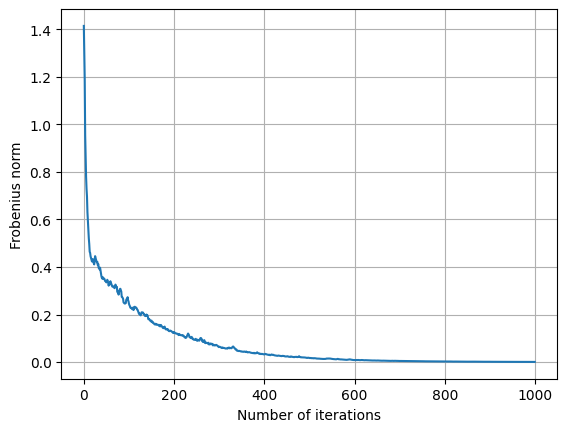

In [63]:
num_iterations = 1000
rng_signals = np.random.default_rng(seed=1)
signals = rng_signals.uniform(low=0, high=1, size=num_iterations)

frobenius_norm = echo_state_property(signals, 4, 2, [2], [3], 10)
plt.plot(frobenius_norm)
plt.xlabel("Number of iterations")
plt.grid()
plt.ylabel("Frobenius norm")


### Exercise 2 - Evaluate model

You will train a quantum system to recall past inputs and evaluate the performance with the memory capacity.

In [ ]:
# 1. Posar un exemple amb una box blava: quins son els inputs i quin són els output

# 2. Donarlis ja train_inputs, train_targets, test_X i test_y


### Exercise 3 - Define your own model

Build your own reservoir and evaluate performance.

Examples:
 - Ising model
 - Bose-Hubbard
 - Previous hamiltonian with qubits.

Have fun and explore!

_Recall: If you feel stuck, you can check: hamiltonian.py_